In [1]:
from copy import deepcopy
import os
import sys

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.dpi'] = 120

figures_dir = "/Users/matsen/writing/talks/figures/bcr-mut-sel/"
# if this path does not exist, set it to ""
if not os.path.exists(figures_dir):
    figures_dir = ""

# default_font_size = plt.rcParams['font.size']
# plt.rcParams.update({'font.size': default_font_size * 1.4})

In [2]:
# compare_df = pd.read_csv("../train/_ignore/mouse_model_compare.csv")
compare_df = pd.read_csv("../train/_ignore/human_model_compare.csv")

# drop rows where crepe_basename is s5f and put them in a separate df called fixed_df
literature_models = ["s5f","cnn_ind_med-shmoof_small"]
fixed_df = compare_df[compare_df["crepe_basename"].isin(literature_models)]
compare_df = compare_df[~compare_df["crepe_basename"].isin(literature_models)]

# split crepe_basename on "-", the first entry is the model name and the second entry is the train dataset
compare_df["model"] = compare_df["crepe_basename"].apply(lambda x: x.split("-")[0])
compare_df["train dataset"] = compare_df["crepe_basename"].apply(lambda x: x.split("-")[1])
compare_df["training method"] = compare_df["crepe_basename"].apply(lambda x: x.split("-")[2])
compare_df["seed"] = compare_df["crepe_basename"].apply(lambda x: x.split("-")[3])
compare_df = compare_df.drop(columns=["crepe_prefix", "crepe_basename"])
compare_df = compare_df.rename(columns={"dataset_name": "test dataset"})
compare_df = compare_df.sort_values(by=["train dataset", "model"]).reset_index(drop=True)

compare_df["model"].unique()
compare_df

,parameter_count,test dataset,AUROC,AUPRC,r-prec,mut_pos_ll,sub_acc,base_ll,overlap,residual,model,train dataset,training method,seed
0,4539,shmoof_small,0.802111,0.103122,0.051961,-0.057064,0.540820,-0.968126,0.920814,0.022968,cnn_ind_med,shmoof_small,fixed,0
1,4539,val_tangshm,0.831215,0.193088,0.128645,-0.133713,0.479132,-1.041828,0.949161,0.018520,cnn_ind_med,shmoof_small,fixed,0
2,4539,shmoof_59,0.814472,0.092802,0.061089,-0.059245,0.564428,-0.932309,0.933072,0.019828,cnn_ind_med,shmoof_small,fixed,0
3,4539,val_syn10x,0.860809,0.211276,0.223873,-0.107626,0.518290,-1.004752,0.000000,1.000000,cnn_ind_med,shmoof_small,fixed,0
4,4539,shmoof_small,0.801349,0.102534,0.053739,-0.057248,0.542183,-0.962668,0.918325,0.023188,cnn_ind_med,shmoof_small,fixed,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,4600,val_syn10x,0.858029,0.200243,0.218738,-0.114159,0.510624,-1.011144,0.000000,1.000000,rsshmoof,shmoof_small,full,1
92,4600,shmoof_small,0.799680,0.102514,0.052180,-0.057361,0.532098,-0.968466,0.915944,0.023439,rsshmoof,shmoof_small,full,2
93,4600,val_tangshm,0.825544,0.187533,0.119702,-0.135460,0.475088,-1.038177,0.931554,0.023698,rsshmoof,shmoof_small,full,2
94,4600,shmoof_59,0.813113,0.089579,0.053501,-0.059440,0.558355,-0.942448,0.943648,0.017070,rsshmoof,shmoof_small,full,2


In [3]:
df = compare_df.copy()

# drop any rows where model matches 4k or 8k
df = df[~df.model.str.contains("4k")]
df = df[~df.model.str.contains("8k")]

# For every row with rsshmoof as the model subtract off 4**5 from the parameter
# count, correspding to every possible 5mer getting mutated to itself. We handle
# this setting indirectly by zeroing out the WT prediction.
def fiddle_parameter_count(row):
    if row["model"] in ["rsshmoof", "origshmoof"]:
        # This corresponds to every 5mer being mutated to itself.
        return row["parameter_count"] - 4**5
    elif row["model"] in ["fivemer"]:
        # This corresponds to every 5mer being mutated to itself, and also 
        # the fact that for the parameterization we're using rates and
        # conditional probabilities, which are only used as a product 
        # so the effective number of parameters is less.
        return row["parameter_count"] - 2 * 4**5
    else:
        return row["parameter_count"]
df["parameter_count"] = df.apply(fiddle_parameter_count, axis=1)

# Dictionaries for translation
model_translations = {
    "fivemer": "5mer",
    "rsshmoof": "Spisak",
    "cnn": "CNN",
    "ind": "Indep",
    "joi": "Joined",
    "hyb": "Hybrid",
    "sml": "Small",
    "med": "Medium",
    "lrg": "Large",
    "4k": "4K"
}

def create_long_name(row):
    parts = row["model"].split('_')
    # Translate each part using the model_translations dictionary
    full_name_parts = [model_translations.get(part, part) for part in parts]
    # Special handling for models without underscores
    if len(full_name_parts) == 1:
        full_name = model_translations.get(row["model"], row["model"])
    else:
        # Join the translated parts with spaces for CNN models
        full_name = ' '.join(full_name_parts[:-1]) + " " + full_name_parts[-1]
    #return f"{full_name} ({row['parameter_count']})"
    return f"{full_name} ({row['parameter_count']}) {row['training method']}"

# Apply the transformation to create the long_name column
df['long_name'] = df.apply(create_long_name, axis=1)

# sort df by parameter count
df = df.sort_values(by="parameter_count", kind="mergesort")
# reverse stable sort by test dataset   
df = df.sort_values(by="test dataset", kind="mergesort")

# extract the rows where "test dataset" is "val_oracleshmoofcnn10k" and put them in a separate df called oracle_df
for (oracle_data, oracle_data_nickname) in [("val_oracleshmoofcnn10k", "shmoof_small"), ("val_oracletangcnn", "val_tangshm")]:
    oracle_df = df[df["test dataset"] == oracle_data]
    df = df[df["test dataset"] != oracle_data]

    # drop all rows where model isn't cnn_joi_lrg
    oracle_df = oracle_df[oracle_df["model"] == "cnn_joi_lrg"]
    oracle_df["test dataset"] = oracle_data_nickname
    oracle_df["long_name"] = "Oracle"

    # append oracle_df to df
    df = pd.concat([df, oracle_df])

df["long_name"].unique(), df["model"].unique()

(array(['CNN Joined Large (2057) fixed', 'CNN Joined Large (2057) full',
        '5mer (3077) fixed', '5mer (3077) full', 'Spisak (3576) fixed',
        'Spisak (3576) full', 'CNN Indep Medium (4539) fixed',
        'CNN Indep Medium (4539) full'], dtype=object),
 array(['cnn_joi_lrg', 'fivemer', 'rsshmoof', 'cnn_ind_med'], dtype=object))

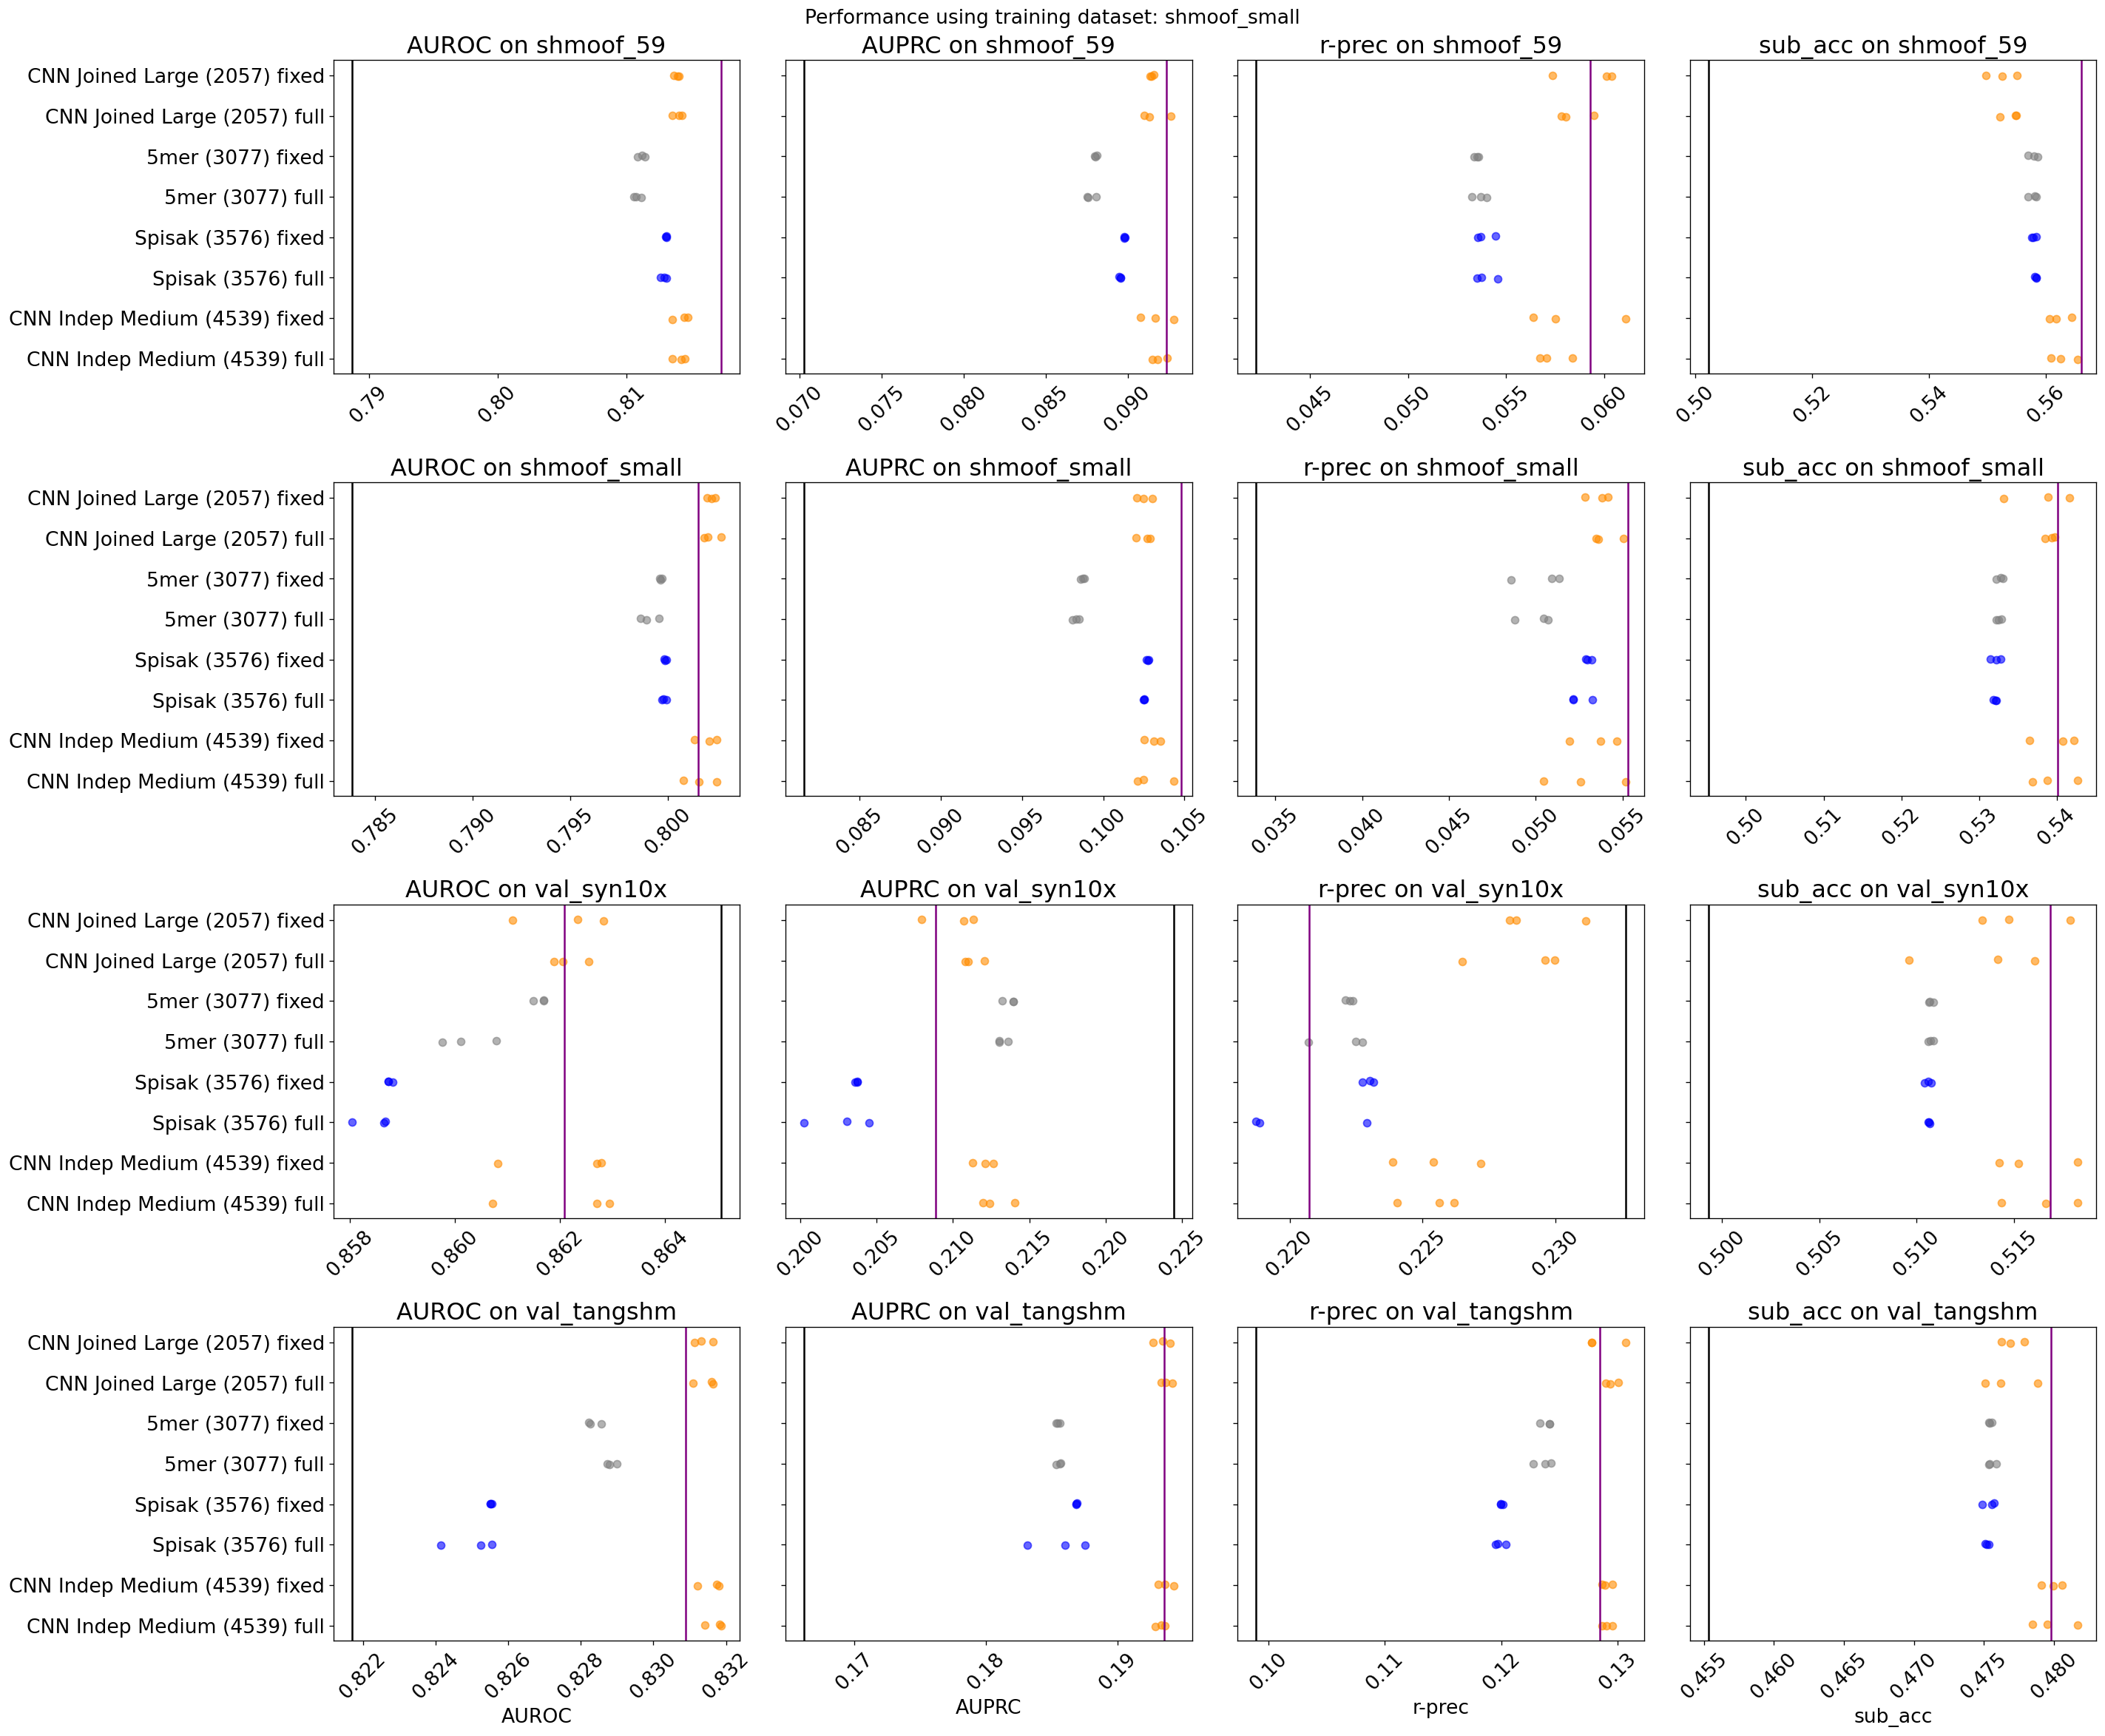

In [6]:
def plot_performance(df, include_shmoof, include_baseline = False, train_dataset = "shmoof_small"):
    baseline_model = "s5f"
    reference_model = "cnn_ind_med-shmoof_small"
    df = df.copy()
    df = df[df["long_name"] != "Oracle"]
    df = df[df["model"] != "cnn_hyb_sml"]
    if not include_shmoof:
        df = df[df["model"] != "rsshmoof"]

    # Assuming df is your DataFrame
    stats = ['AUROC', 'AUPRC', 'r-prec', 'sub_acc']
    train_datasets = df['train dataset'].unique()
    test_datasets = df['test dataset'].unique()
    unique_long_names = df['long_name'].unique()[::-1]
    name_to_y = {name: i for i, name in enumerate(unique_long_names)}

    # Setup figure parameters, transposing nrows with ncols
    nrows = len(test_datasets)
    ncols = len(stats)

    # Define the jitter range for the y-values
    jitter_strength = 0.05  # Smaller for subtler jitter

    # Loop through each training dataset to create separate figures or subplot grids
    # for train_dataset in train_datasets:
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows), squeeze=False, sharey=True)
    # set font size for fig
    plt.rcParams.update({'font.size': 16})
    fig.suptitle(f'Performance using training dataset: {train_dataset}', fontsize=16)

    for row_idx, test_dataset in enumerate(test_datasets):
        # Filter the DataFrame for models trained on `train_dataset` and tested on `test_dataset`
        df_filtered = df[(df['train dataset'] == train_dataset) & (df['test dataset'] == test_dataset)].copy()

        baseline_values = fixed_df.query("dataset_name == @test_dataset and crepe_basename == @baseline_model").reset_index(drop=True).iloc[0]
        reference_values = fixed_df.query("dataset_name == @test_dataset and crepe_basename == @reference_model").reset_index(drop=True).iloc[0]

        for col_idx, stat in enumerate(stats):
            if not df_filtered.empty:
                df_filtered[stat + '_relative'] = df_filtered[stat] - baseline_values[stat]
                df_filtered = df_filtered.sort_values(by="parameter_count", ascending=False)

                ax = axes[row_idx, col_idx]

                # Plot each point, adding jitter around the assigned y-value
                for i, row in df_filtered.iterrows():
                    y_pos = name_to_y[row['long_name']] + (np.random.rand() - 0.5) * jitter_strength
                    # if row["model"] contains ("cnn"):
                    if row["model"][:3] == "cnn":
                        color = "darkorange"
                    elif row["model"] == "rsshmoof":
                        color = "blue"
                    else:
                        color = "gray"
                    ax.scatter(row[stat], y_pos, color=color, alpha=0.6)

                ax.axvline(x=baseline_values[stat], color='k')
                ax.axvline(x=reference_values[stat], color='purple')

                ax.set_yticks(np.arange(len(unique_long_names)))
                ax.set_yticklabels(unique_long_names)
                ax.set_title(f"{stat} on {test_dataset}")
                ax.tick_params(axis='x', rotation=45)
                if row_idx == nrows - 1:  # Only set x-labels for the bottom row
                    ax.set_xlabel(f'{stat}')
    fig.tight_layout()
    filename = "performance"
    if include_shmoof:
        filename += "_with_shmoof"
    if include_baseline:
        filename += "_with_baseline"
    fig.savefig(os.path.join(figures_dir, f"{filename}.svg"))

#plot_performance(df, include_shmoof=False)
plot_performance(df, include_shmoof=True)
#plot_performance(df, include_shmoof=True, include_baseline=True)
